In [1]:
# Libraries

# Data handling 
import pandas as pd
import numpy as np

# Feature transformation
from sklearn import preprocessing 

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# read the file
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('./files/training.zip', sep = ',', compression = 'zip')

In [3]:
# remove outliers
# Outlier removal 
df = df[df['claim_amount'] <= 9000]

In [4]:
# calculate y
df.head()

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,drv_age1,drv_age_lic1,drv_drv2,drv_sex2,drv_age2,drv_age_lic2,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
0,PL000000,1.0,0.332,Med2,5,1,Monthly,No,WorkPrivate,M,35.0,16.0,Yes,F,26.0,1.0,aparvvfowrjncdhp,8.0,Gasoline,Tourism,174.0,11040.0,1143.0,1270.0,33.1,0.0
1,PL042495,1.0,0.000,Med2,6,1,Monthly,No,WorkPrivate,M,60.0,41.0,No,0,NaN,NaN,aparvvfowrjncdhp,10.0,Diesel,Tourism,174.0,11040.0,1143.0,1290.0,51.3,0.0
2,PL042496,1.0,0.196,Med1,2,1,Yearly,Yes,Retired,M,55.0,35.0,Yes,F,57.0,38.0,iwhqpdfuhrsxyqxe,8.0,Diesel,Commercial,150.0,14159.0,1193.0,1020.0,262.8,0.0
3,PL042497,1.0,0.000,Med2,8,5,Yearly,No,WorkPrivate,F,54.0,31.0,No,0,NaN,NaN,kvcddisqpkysmvvo,4.0,Gasoline,Tourism,149.0,17233.0,1012.0,180.0,219.7,0.0
4,PL042498,1.0,0.000,Med1,2,2,Yearly,No,Retired,F,65.0,38.0,No,0,NaN,NaN,tdgkjlphosocwbgu,13.0,Gasoline,Tourism,200.0,19422.0,1315.0,30.0,70.3,0.0


In [5]:
# New variable binary 0 means not claim and 1 means claim 
df['claim'] = df['claim_amount'].apply(lambda x: 0 if x == 0.0 else 1)

# Counter of the df
df['counts'] = 1

# Continous vars grouped by id_policy
df_policyid = df.groupby('id_policy')[['claim_amount','claim','counts']].sum()
df_policyid['occurence']  =  df_policyid['claim'] / df_policyid['counts'] # number of accidents per years of policy
df_policyid['severity']  =  df_policyid['claim_amount'] / df_policyid['counts'] # average amount of claim per years of policy
df_policyid2 = df.groupby('id_policy')[['pol_no_claims_discount','pol_duration','pol_sit_duration',
                                       'drv_age1','drv_age_lic1','vh_age','vh_speed','vh_value',
                                       'population','town_surface_area']].mean()

df_policyid2 = df_policyid.merge(df_policyid2, left_index = True, right_index = True)

# Calculation of possible indicators for the model


# merge continous variables
df_pol = df_policyid2.merge(df_policyid, right_index = True, left_index = True)

# dummy variables to work with
dummies = ['pol_coverage', 'pol_pay_freq', 'pol_payd', 'pol_usage', 'drv_sex1', 'drv_drv2', 'vh_fuel', 'vh_type' ]
df_dummies = pd.get_dummies(df[dummies])
df_dummies = df.merge(df_dummies, right_index = True, left_index = True)

# dummy dataset created - excluded variables are not able to be grouped by calculating the mean 
df_dummies_g_ = df_dummies.groupby('id_policy')[['pol_coverage_Max',
       'pol_coverage_Med1', 'pol_coverage_Med2', 'pol_coverage_Min',
       'pol_payd_No','pol_payd_Yes', 'pol_usage_AllTrips', 
       'pol_usage_Professional','pol_usage_Retired',
       'pol_usage_WorkPrivate', 'drv_drv2_No', 'drv_drv2_Yes', 'vh_fuel_Diesel',
       'vh_fuel_Gasoline', 'vh_fuel_Hybrid', 'vh_type_Commercial',
       'vh_type_Tourism']].mean()

# df with the final values
df_final = df_dummies_g_.merge(df_policyid2, right_index = True, left_index = True)

In [6]:
df_final.shape

(57054, 32)

In [7]:
df_final.describe()

,pol_coverage_Max,pol_coverage_Med1,pol_coverage_Med2,pol_coverage_Min,pol_payd_No,pol_payd_Yes,pol_usage_AllTrips,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,drv_drv2_No,drv_drv2_Yes,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_type_Commercial,vh_type_Tourism,claim_amount,claim,counts,occurence,severity,pol_no_claims_discount,pol_duration,pol_sit_duration,drv_age1,drv_age_lic1,vh_age,vh_speed,vh_value,population,town_surface_area
count,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57054.000000,57053.000000,56416.000000,56416.000000,57054.000000,57054.000000
mean,0.642006,0.095488,0.175588,0.086918,0.958285,0.041715,0.000911,0.070302,0.271620,0.657167,0.669962,0.330038,0.543082,0.456024,0.000894,0.099555,0.900445,435.198497,0.407193,3.998948,0.101845,108.889578,0.044393,12.608687,4.245084,56.339363,34.132401,11.139809,170.946434,17699.659476,570.632296,205.036926
std,0.479415,0.293891,0.380473,0.281717,0.199939,0.199939,0.030176,0.255657,0.444799,0.474660,0.470231,0.470231,0.498145,0.498067,0.029885,0.299408,0.299408,1027.490983,0.657416,0.032412,0.164439,257.214788,0.114567,8.566224,2.371824,14.937051,13.856154,7.047404,25.550186,10535.676301,669.296291,162.572830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2.333333,2.000000,20.500000,2.500000,2.000000,95.000000,1113.000000,0.000000,18.500000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,5.500000,2.500000,45.500000,23.500000,5.500000,155.000000,11490.000000,180.000000,82.600000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,10.500000,3.500000,55.500000,34.500000,9.500000,174.000000,16321.000000,320.000000,155.600000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,359.960000,1.000000,4.000000,0.250000,89.990000,0.000000,17.500000,4.500000,66.500000,44.500000,14.500000,183.000000,22067.000000,610.000000,288.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16047.110000,4.000000,4.000000,1.000000,4011.777500,0.957000,42.500000,24.500000,102.500000,78.500000,62.500000,251.000000,101525.000000,2550.000000,745.400000


In [43]:
vehvars = ['vh_make_model','vh_age','vh_fuel','vh_type','vh_speed','vh_value','vh_weight']
drivvars = ['drv_sex1','drv_age1','drv_age_lic1','drv_drv2','drv_sex2','drv_age2','drv_age_lic2']
polvars = ['pol_no_claims_discount','pol_coverage','pol_duration','pol_sit_duration','pol_payd','pol_usage']
demog = ['population','town_surface_area']

In [ ]:
# Introduce the variables

In [ ]:
# log linear variables

In [8]:
# generate a weight factor 
df_weight = (df_final.groupby('severity')['counts'].count()).reset_index()
df_weight['severity2'] =  df_weight['severity']
df_weight.head()

,severity,counts,severity2
0,0.0000,38551,0.0000
1,0.0250,1,0.0250
2,0.0575,1,0.0575
3,0.0850,1,0.0850
4,0.1075,1,0.1075


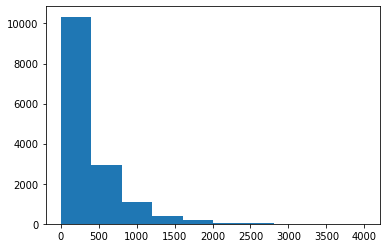

In [9]:
plt.hist(df_weight['severity'])
plt.show()

In [10]:
bin_label = np.arange(0, 4011.7775000000006, 80.23555000000002).tolist()
df_weight['severity2'] = pd.cut(df_weight['severity'], 50, labels = bin_label).astype(int)
df_weight2 = df_weight.groupby('severity2')['counts'].sum().reset_index()

In [33]:
df_weight2['severity2'] = df_weight2['severity2'].apply(lambda x: 1 if x == 0 else x)
df_weight2['weight'] = (df_weight2['severity2'] * df_weight2['counts']) / np.sum(df_weight2['severity2'] * df_weight2['counts']) * 100
df_weight2.head()

,severity2,counts,weight
0,1,42289,0.769809
1,80,3815,5.555716
2,160,1987,5.787265
3,240,2786,12.171606
4,320,1082,6.302789


In [39]:
df_weight.head()

,severity,counts,severity2
0,0.0000,38551,0
1,0.0250,1,0
2,0.0575,1,0
3,0.0850,1,0
4,0.1075,1,0


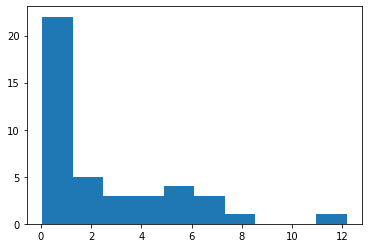

In [38]:
plt.hist(df_weight2['weight'])
plt.show()

In [ ]:
# offset variables